In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import kpss, adfuller, ccf, ccovf
from statsmodels.iolib.smpickle import load_pickle

In [2]:
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector, FloatVector
import rpy2

Unable to determine R home: [WinError 2] 系統找不到指定的檔案。
Exception in thread Thread-4:
Traceback (most recent call last):
  File "C:\Users\Jater\.pyenv\pyenv-win\versions\3.8.9\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\Jater\.pyenv\pyenv-win\versions\3.8.9\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Jater\.pyenv\pyenv-win\versions\3.8.9\lib\subprocess.py", line 1370, in _readerthread
    buffer.append(fh.read())
  File "C:\Users\Jater\.pyenv\pyenv-win\versions\3.8.9\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xbf in position 0: invalid start byte
Unable to determine R library path: Command '('C:\\Program Files\\R\\R-4.1.2\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.


In [3]:
mts = rpackages.importr('MTS')

### 讀取資料

In [4]:
horizon = pd.read_csv(".\\data\\horizon_multivariate_final.csv", encoding="utf-8")
horizon_diff = horizon.diff().dropna()
horizon.head()

,Average Effective Clock,CPU Overall Power Consumption,GPU Power,GPU Effective Clock,FPS
0,2295.4,99.895,305.353,1950.3,113
1,2598.2,104.135,341.418,1941.3,146
2,2741.5,107.012,345.209,1948.2,147
3,2660.6,105.918,342.610,1937.2,150
4,2598.3,103.853,345.456,1936.8,152


In [5]:
def plot_ccf(x, y, ax,lags=10):
    '''
        x, y: The time series data to use in the calculation.
    '''
    CCF = ccf(x, y)[:lags+1]
    for (i, v) in enumerate(CCF):
        ax.vlines(x=i, ymin=0, ymax=v, colors="r")
    ax.hlines(y=0, xmin=0, xmax=lags, colors="b")
    ax.set_xlabel("lags")
    ax.set_ylabel("ccf")
    ax.grid()
    return ax

### CCF

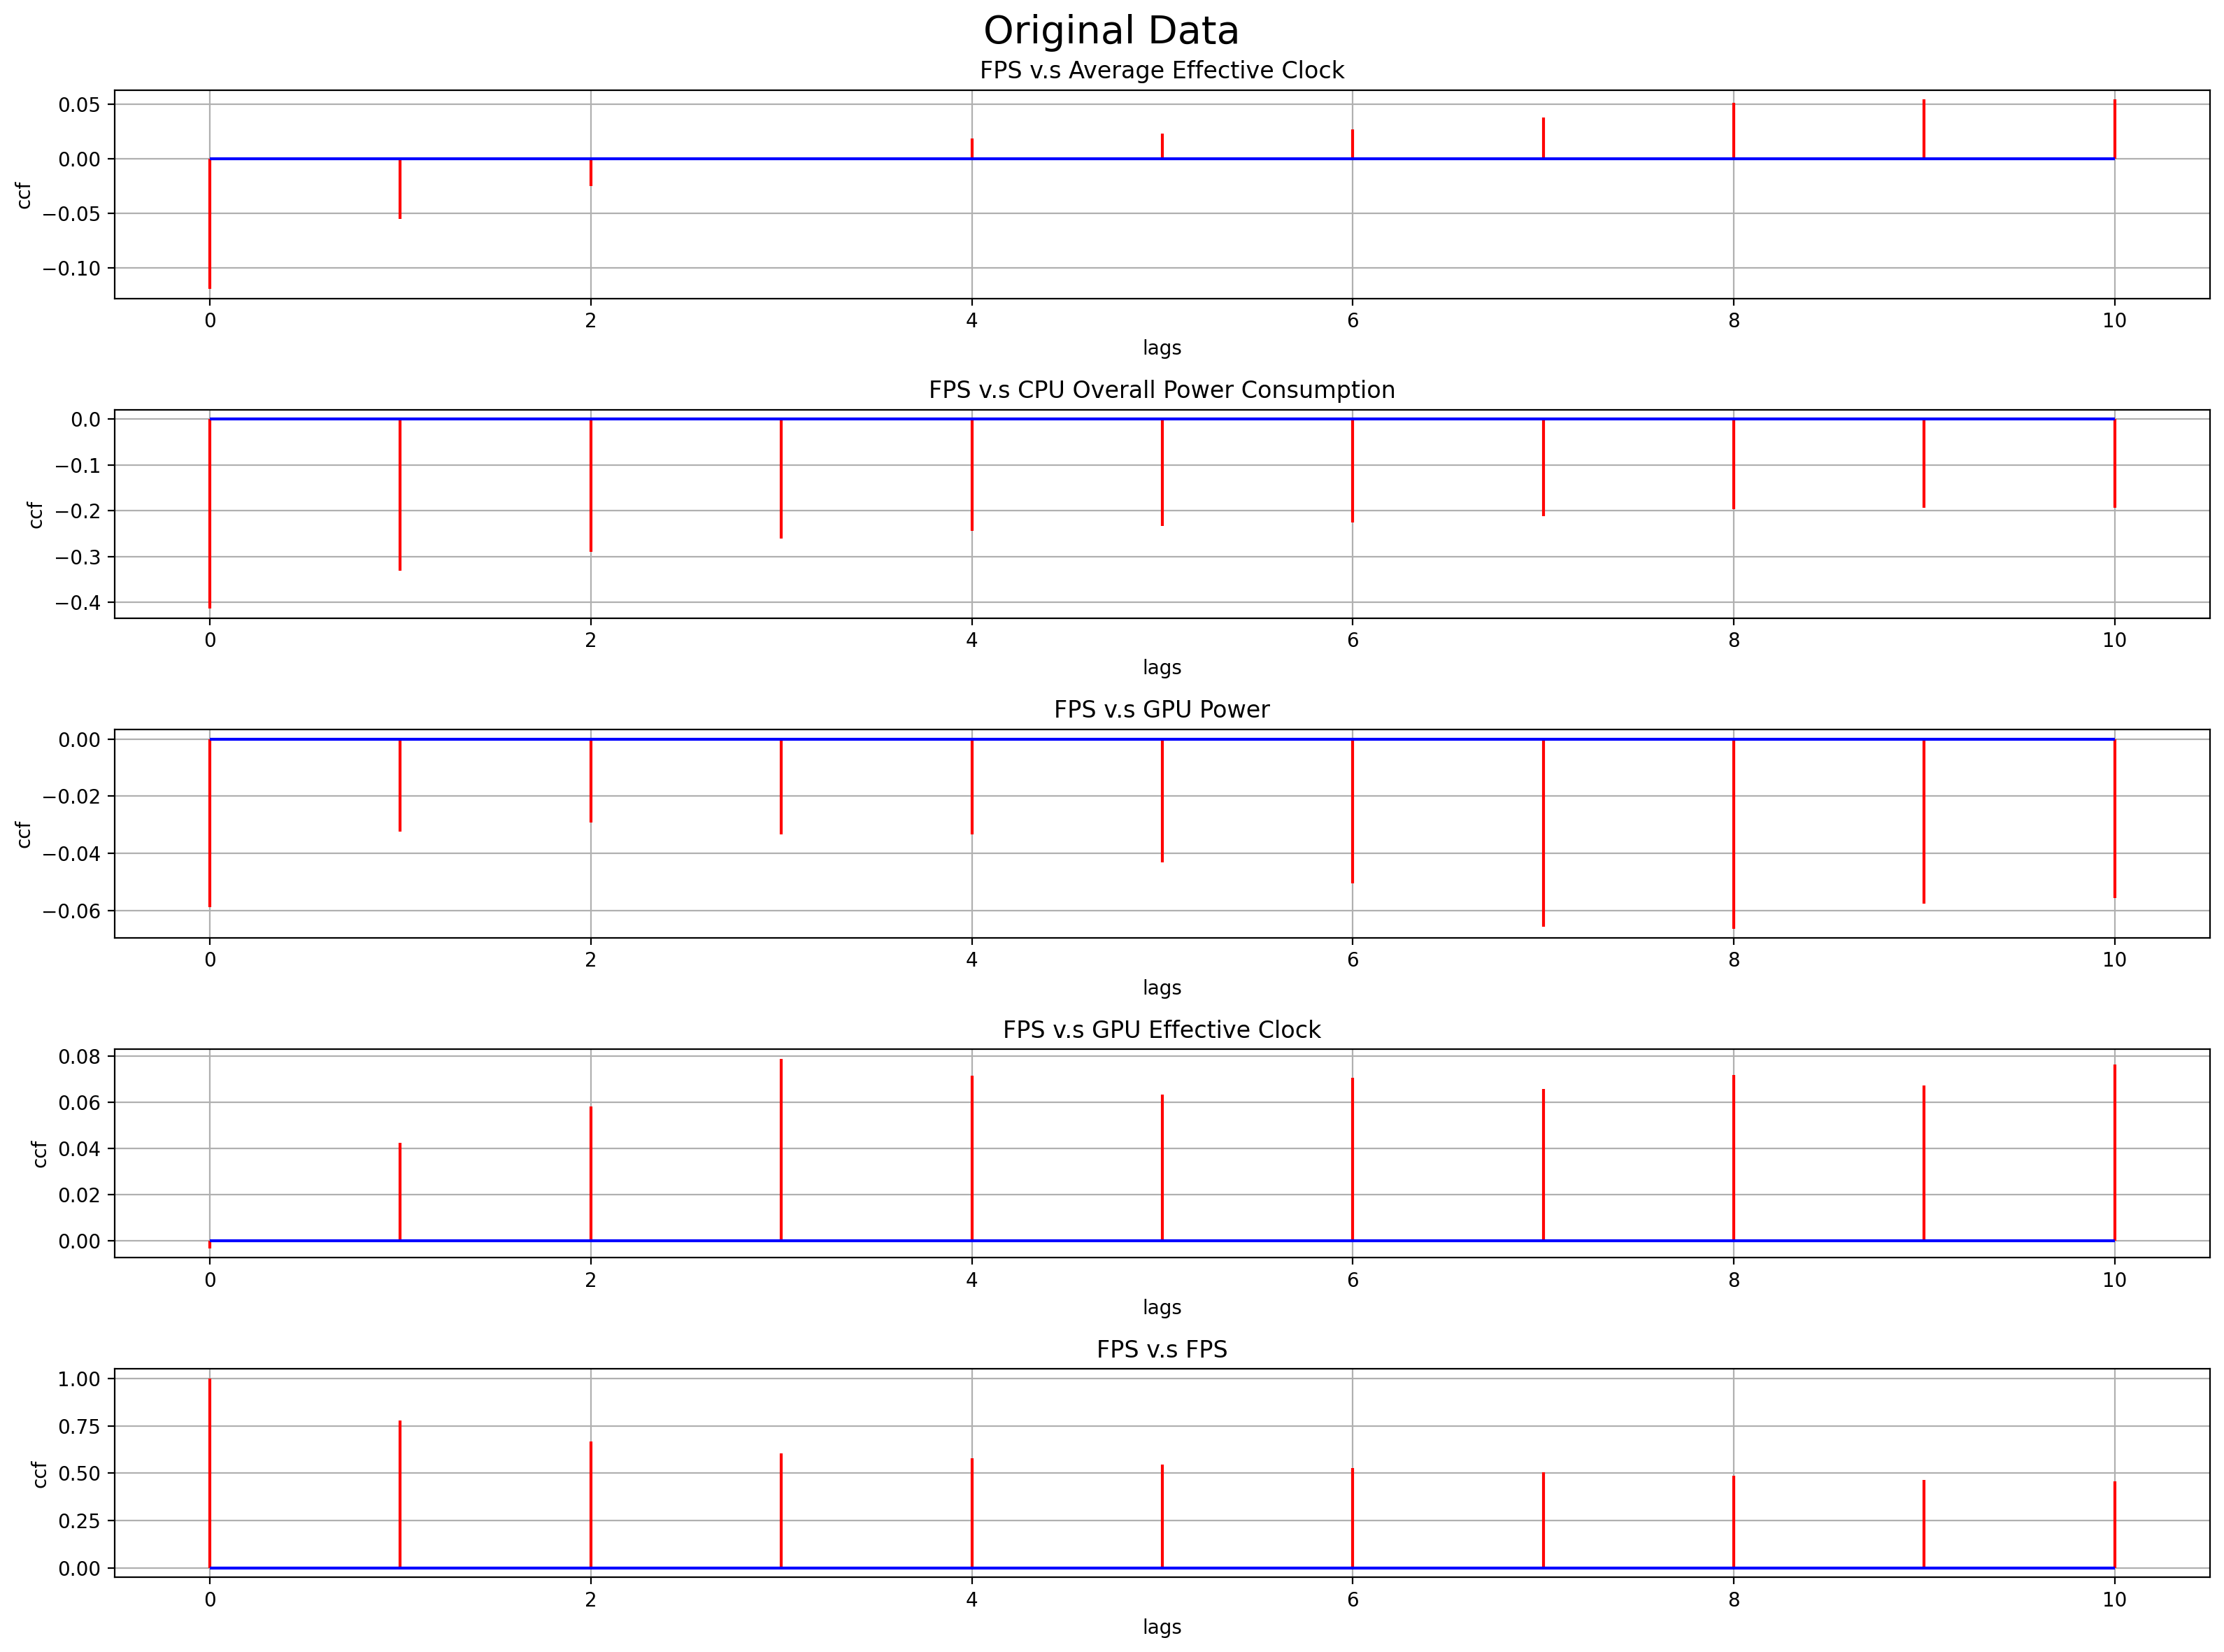

: 

In [34]:
fig, ax = plt.subplots(5, 1, figsize=(16, 12), dpi=200)
fig.suptitle("Original Data", fontsize=20)
for (i, v) in enumerate(horizon.columns):
    plot_ccf(horizon["FPS"], horizon.iloc[:, i], ax[i])
    ax[i].set_title(f"FPS v.s {v}")
fig.tight_layout()
plt.show()

In [7]:
for (i, v) in enumerate(horizon.columns):
    print(f"Cross-Correlation of FPS and {v}")
    print(ccf(horizon["FPS"], horizon.iloc[:, i])[:5], end="\n")
    print("\n")

Cross-Correlation of FPS and Average Effective Clock
[-0.11898895 -0.05487867 -0.02517316 -0.00079945  0.01835077]


Cross-Correlation of FPS and CPU Overall Power Consumption
[-0.41424525 -0.33171016 -0.29061736 -0.26154854 -0.24444743]


Cross-Correlation of FPS and GPU Power
[-0.05872975 -0.03241151 -0.02923181 -0.03339628 -0.03342009]


Cross-Correlation of FPS and GPU Effective Clock
[-0.00320556  0.04244094  0.05803949  0.0787766   0.07155468]


Cross-Correlation of FPS and FPS
[1.         0.77874737 0.66603596 0.60488109 0.57878294]




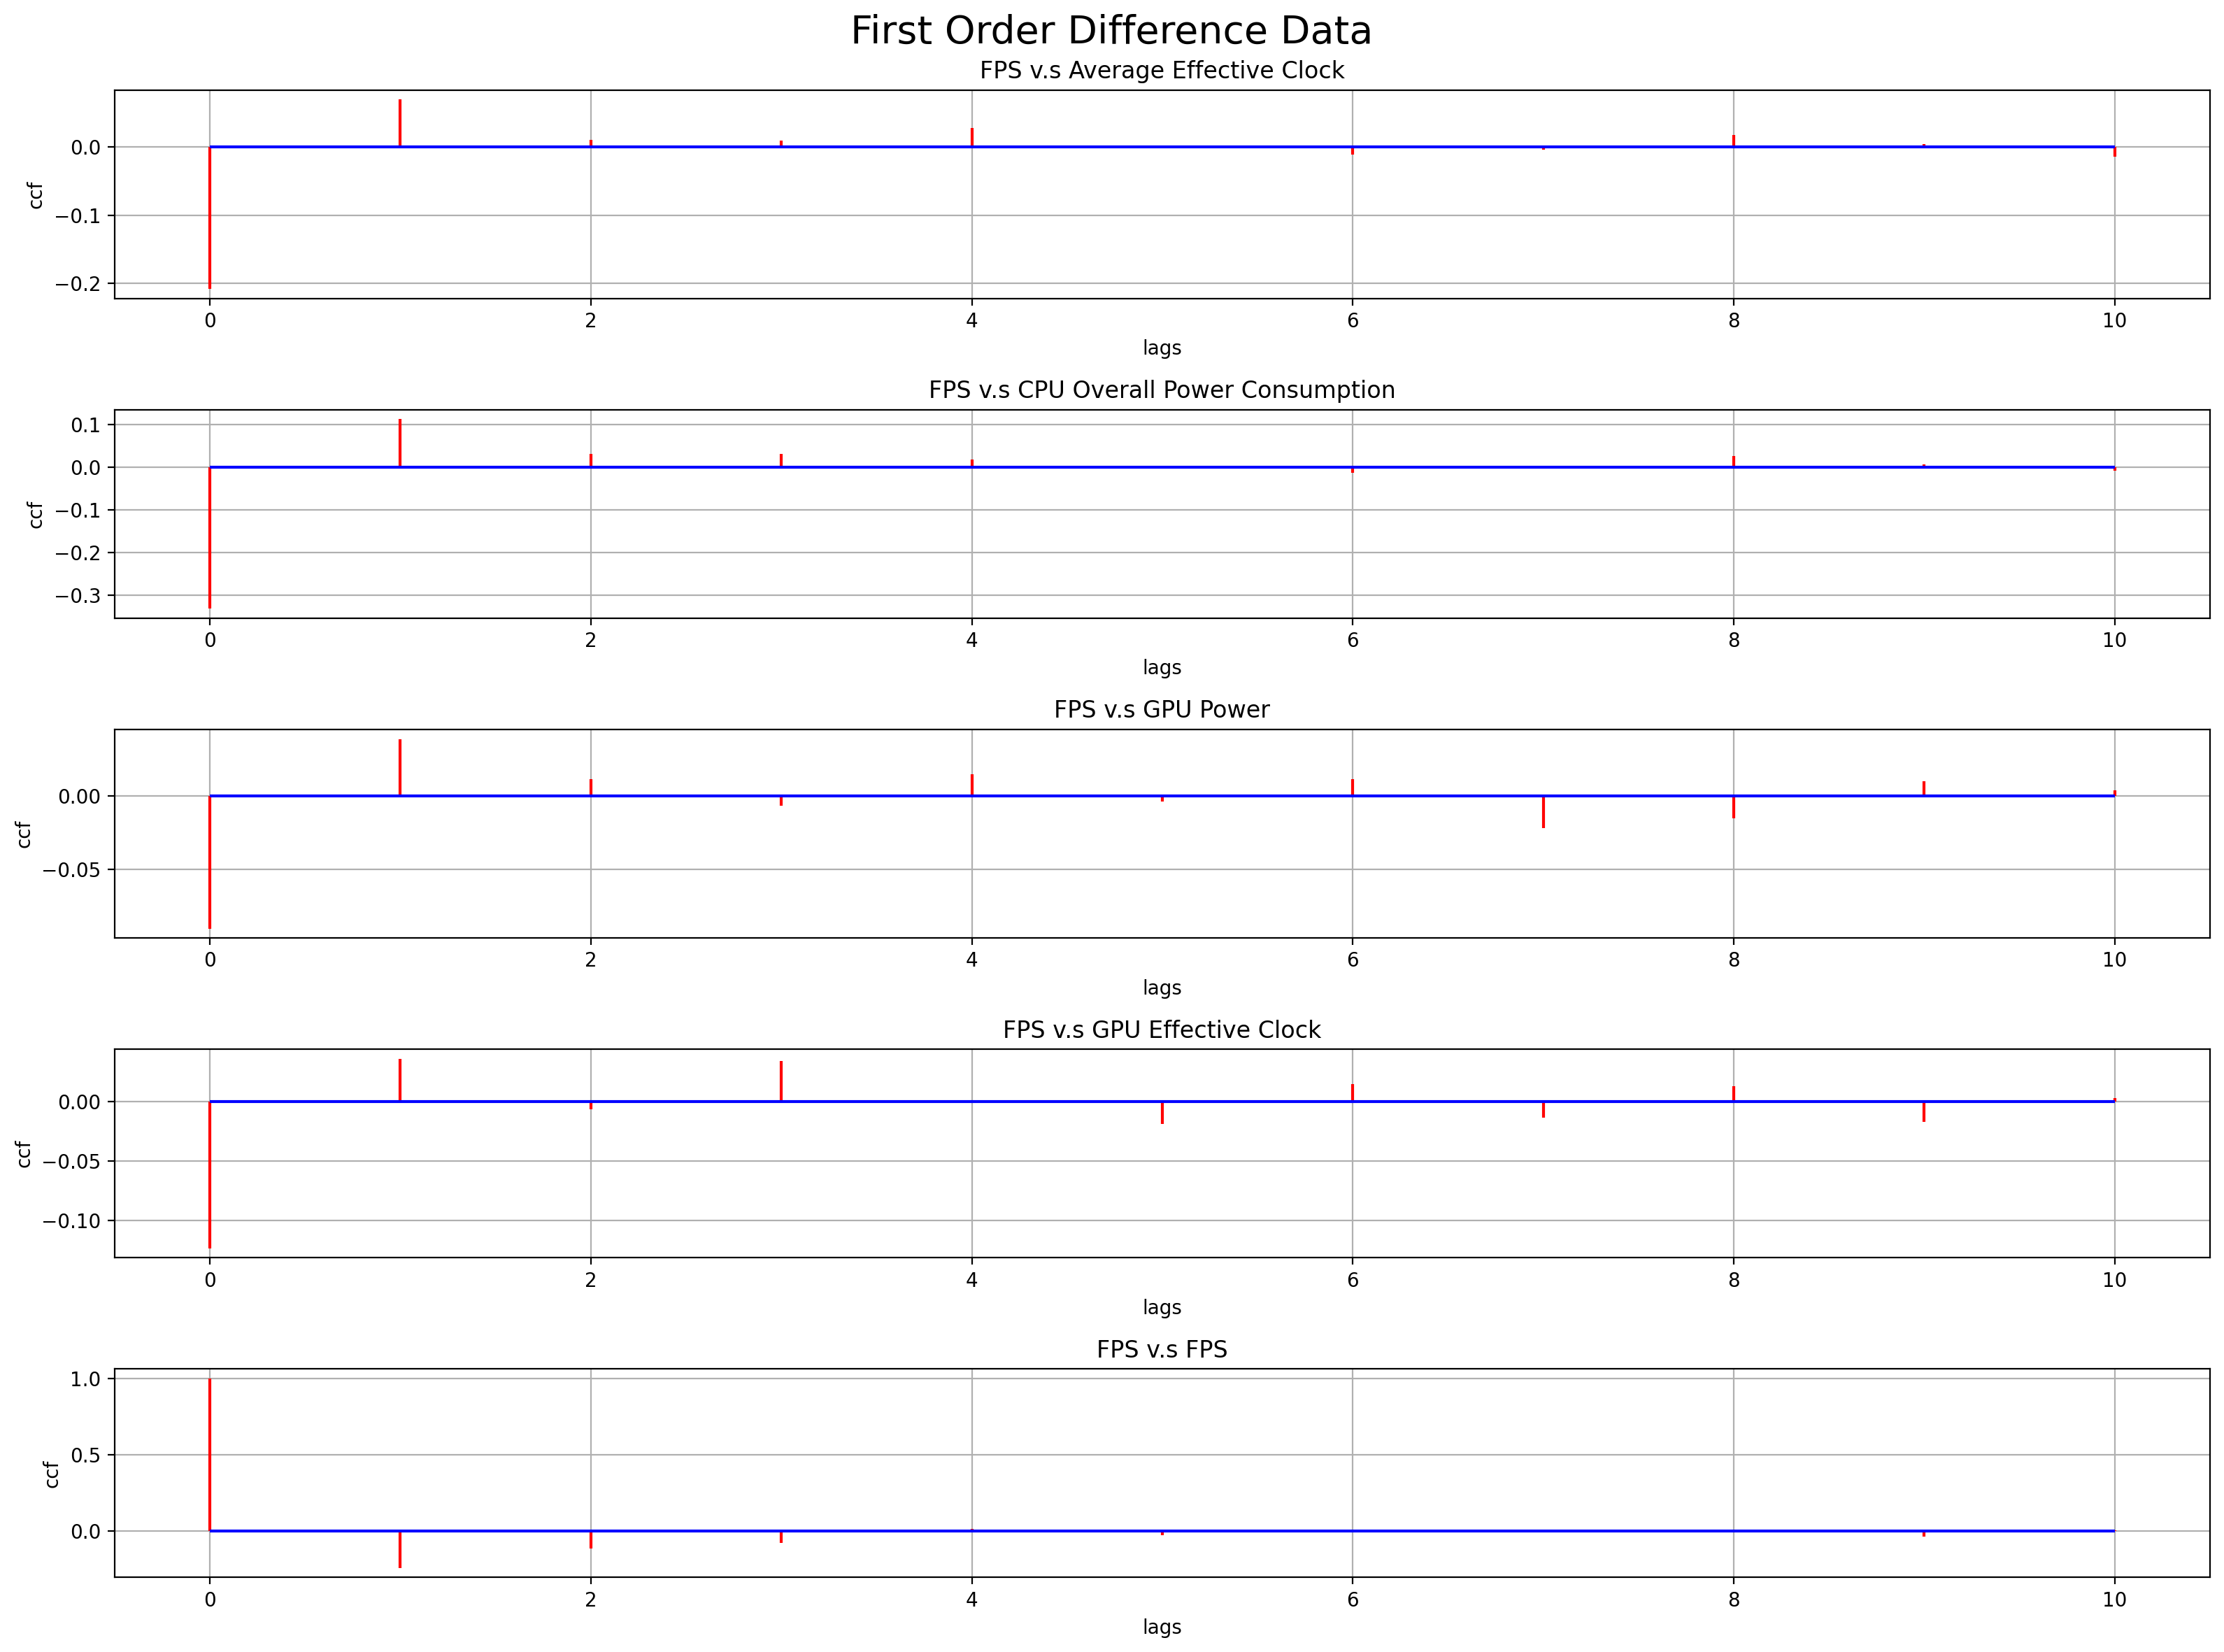

In [33]:
fig, ax = plt.subplots(5, 1, figsize=(16, 12), dpi=200)
fig.suptitle("First Order Difference Data", fontsize=20)
for (i, v) in enumerate(horizon_diff.columns):
    plot_ccf(horizon_diff["FPS"], horizon_diff.iloc[:, i], ax[i])
    ax[i].set_title(f"FPS v.s {v}")
fig.tight_layout()
plt.show()

In [9]:
for (i, v) in enumerate(horizon_diff.columns):
    print(f"Cross-Correlation of FPS and {v}")
    print(ccf(horizon_diff["FPS"], horizon_diff.iloc[:, i])[:5], end="\n")
    print("\n")

Cross-Correlation of FPS and Average Effective Clock
[-0.20796158  0.06981203  0.01016084  0.00975639  0.02750257]


Cross-Correlation of FPS and CPU Overall Power Consumption
[-0.33217008  0.11286205  0.03061975  0.03112115  0.0174612 ]


Cross-Correlation of FPS and GPU Power
[-0.0906405   0.03925685  0.01163069 -0.00653001  0.01530919]


Cross-Correlation of FPS and GPU Effective Clock
[-0.12310596  0.03607353 -0.00615324  0.0339539   0.00112748]


Cross-Correlation of FPS and FPS
[ 1.         -0.2430601  -0.11673354 -0.07965096  0.01142009]




### OLS

In [10]:
model = sm.OLS(
    horizon["FPS"],
    sm.add_constant(horizon[["Average Effective Clock", "CPU Overall Power Consumption", "GPU Power", "GPU Effective Clock"]])
)
result = model.fit()

In [11]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    FPS   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     302.3
Date:                Fri, 10 Jun 2022   Prob (F-statistic):          1.09e-220
Time:                        21:39:45   Log-Likelihood:                -12869.
No. Observations:                3193   AIC:                         2.575e+04
Df Residuals:                    3188   BIC:                         2.578e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           313.1523      9.637     32.494      0.000     294.256     332.048
Average Effective Clock           0.0462      0.002     20.054      0.000       0.042       0.051
CPU Overall Power Consumption    -2.1186      0.063    -33.445      0.000      -2.243      -1.994
GPU Power                        -0.1482      0.020     -7.512      0.000      -0.187      -0.110
GPU Effective Clock               0.0065      0.005      1.217      0.224      -0.004       0.017
==============================================================================
Omnibus:                       55.343   Durbin-Watson:                   0.505
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.223
Skew:                           0.313   Prob(JB):                     2.28e-13
Kurtosis:                       3.212   Cond. No.                     1.40e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### OLS with First Order Difference

In [12]:
model_diff = sm.OLS(
    horizon_diff["FPS"],
    sm.add_constant(horizon_diff[["Average Effective Clock", "CPU Overall Power Consumption", "GPU Power", "GPU Effective Clock"]])
)
result_diff = model_diff.fit()

In [13]:
result_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    FPS   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     209.7
Date:                Fri, 10 Jun 2022   Prob (F-statistic):          6.80e-160
Time:                        21:39:45   Log-Likelihood:                -11702.
No. Observations:                3192   AIC:                         2.341e+04
Df Residuals:                    3187   BIC:                         2.345e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0196      0.168      0.117      0.907      -0.309       0.348
Average Effective Clock           0.0713      0.004     19.238      0.000       0.064       0.079
CPU Overall Power Consumption    -3.4166      0.136    -25.129      0.000      -3.683      -3.150
GPU Power                        -0.1409      0.018     -7.831      0.000      -0.176      -0.106
GPU Effective Clock              -0.0011      0.003     -0.313      0.754      -0.008       0.006
==============================================================================
Omnibus:                      362.029   Durbin-Watson:                   2.665
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2953.335
Skew:                          -0.205   Prob(JB):                         0.00
Kurtosis:                       7.694   Cond. No.                         135.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Multivariate Ljung-Box statistics for cross-correlation matrices

In [14]:
horizon_diff_vector = horizon_diff.to_numpy().flatten()

In [15]:
mts.mq(rpy2.robjects.r.matrix(FloatVector(horizon_diff_vector), ncol=4), lag=24)

Ljung-Box Statistics:  
         m       Q(m)     df    p-value
 [1,]    1.0      33.6    16.0     0.01
 [2,]    2.0      71.7    32.0     0.00
 [3,]    3.0     232.7    48.0     0.00
 [4,]    4.0     246.6    64.0     0.00
 [5,]    5.0    1475.8    80.0     0.00
 [6,]    6.0    1477.2    96.0     0.00
 [7,]    7.0    1485.0   112.0     0.00
 [8,]    8.0    1511.6   128.0     0.00
 [9,]    9.0    1513.1   144.0     0.00
[10,]   10.0    2121.5   160.0     0.00
[11,]   11.0    2122.4   176.0     0.00
[12,]   12.0    2134.6   192.0     0.00
[13,]   13.0    2176.2   208.0     0.00
[14,]   14.0    2177.3   224.0     0.00
[15,]   15.0    2230.2   240.0     0.00
[16,]   16.0    2231.3   256.0     0.00
[17,]   17.0    2245.0   272.0     0.00
[18,]   18.0    2270.2   288.0     0.00
[19,]   19.0    2270.8   304.0     0.00
[20,]   20.0    2300.2   320.0     0.00
[21,]   21.0    2300.9   336.0     0.00
[22,]   22.0    2318.5   352.0     0.00
[23,]   23.0    2331.5   368.0     0.00
[24,]   24.0    

<rpy2.rinterface_lib.sexp.NULLType object at 0x000001A99179D5C0> [RTYPES.NILSXP]